# FASTTEXT POUR PREDIRE PAGE AVEC TABLEAU

In [1]:
import s3fs
import hvac
import os

client = hvac.Client(url='https://vault.lab.sspcloud.fr',
                     token=os.environ['VAULT_TOKEN'])
secret = os.environ['VAULT_MOUNT'] + os.environ['VAULT_TOP_DIR'] + '/s3_creds'
mount_point, secret_path = secret.split('/', 1)
secret_dict = client.secrets.kv.read_secret_version(path=secret_path, mount_point = mount_point)
os.environ["AWS_ACCESS_KEY_ID"] = secret_dict['data']['data']['ACCESS_KEY']
os.environ["AWS_SECRET_ACCESS_KEY"] = secret_dict['data']['data']['SECRET_KEY']
try:
    del os.environ['AWS_SESSION_TOKEN']
except KeyError:
    pass

In [2]:
import pickle
import json
import mlflow
import os
import sys
sys.path.append("../src/")
sys.path.append("../")
sys.path.append("../src/page_selection/")
from tqdm import tqdm
from time import time

from utils import (
    clean_page_content,
    extract_document_content,
    fit_transform_vectorizer,
    train_random_forest,
)

### Nos données annotées

In [ ]:
# TODO: clean up
with open("../data/updated_labels_filtered.json", "r") as fp:
    labels = json.load(fp)

In [ ]:
labeled_file_names = []
valid_labels = []

i = 0
for file_name, file_labels in labels.items():
    # Keep documents with at least 1 table
    table_count = sum(file_labels)
    if table_count > 0:
        i += 1
        labeled_file_names.append(file_name)
        for label in file_labels:
            valid_labels.append(label)

In [ ]:
corpus = []
labeled_file_names = [
    "projet-extraction-tableaux/raw-comptes/CS_extrait/" + file_name
    for file_name in labeled_file_names
]
identifiers = []

In [ ]:
for file_name in tqdm(labeled_file_names):
    clean_document_content = []
    page_list = extract_document_content(file_name, resolution=200)
    for i, page in enumerate(page_list):
        clean_content = clean_page_content(page)
        clean_document_content.append(clean_content)
        identifiers.append((file_name, i))
    corpus.append(clean_document_content)

In [ ]:
corpus[0]

In [ ]:
flat_corpus = [item for sublist in corpus for item in sublist]

In [ ]:
flat_corpus[:5]

In [ ]:
valid_labels[:5]

In [ ]:
len(flat_corpus) == len(valid_labels)

In [ ]:
len(flat_corpus)

In [ ]:
len(identifiers)

In [ ]:
identifiers

### Données Adem + Laura

In [ ]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
with fs.open("s3://projet-extraction-tableaux/data/df_trainrf.pickle", 'rb') as f:
    df = pickle.load(f)

In [ ]:
df

In [ ]:
flat_corpus2 = list(df.text)
valid_labels2 = list(df.tableau_f_et_p)

In [ ]:
len(flat_corpus2) == len(valid_labels2)

In [ ]:
flat_corpus2[:5]

In [ ]:
valid_labels2[:5]

In [ ]:
flat_corpus2 = [clean_page_content(page) for page in flat_corpus2]

In [ ]:
flat_corpus2[:5]

In [ ]:
df.dtypes

In [ ]:
identifiers2 = [str(siren) + "_" + str(pagenumber - 1) for siren, pagenumber in zip(df.siren, df.pagenumber)]

In [ ]:
len(identifiers2)

In [ ]:
len(flat_corpus2)

### Train FastText

In [ ]:
# from utils import load_labeled_data, load_extra_labeled_data

# flat_corpus, valid_labels = load_labeled_data()
# flat_corpus_extra, valid_labels_extra = load_extra_labeled_data()
# flat_corpus += flat_corpus_extra
# valid_labels += valid_labels_extra

flat_corpus += flat_corpus2
valid_labels += valid_labels2
identifiers += identifiers2

len(flat_corpus)

In [ ]:
len(valid_labels)

In [ ]:
len(identifiers)

In [ ]:
flat_corpus[:5]

On regarde les textes annotés 1 pour vérifier que pas de choses étranges

In [ ]:
len(flat_corpus)

In [ ]:
for text, label, identifier in zip(flat_corpus, valid_labels, identifiers):
    if label == 1:
        print("---")
        print(text)
        print(identifier)

In [ ]:
random_state = 42
test_size = 0.2

train_corpus, test_corpus, y_train, y_test, x_identifiers, y_identifiers = train_test_split(
    flat_corpus,
    valid_labels,
    identifiers,
    test_size=test_size,
    random_state=random_state,
)

In [ ]:
!pip install fasttext

In [ ]:
import fasttext

In [ ]:
params = {
    "dim": 150,
    "lr": 0.275,
    "epoch": 50,
    "wordNgrams": 3,
    "minn": 3,
    "maxn": 4,
    "minCount": 3,
    "bucket": 2000000,
    "thread": 50,
    "loss": "ova",
    "label_prefix": "__label__"
}

In [ ]:
len(train_corpus)

In [ ]:
with open("train_text.txt", "w", encoding="utf-8") as file:
    for lib, label in zip(train_corpus, y_train):
        formatted_item = f"__label__{label} {lib}"
        file.write(f"{formatted_item}\n")

model = fasttext.train_supervised(
    "train_text.txt", **params, verbose=2
)

In [ ]:
res = model.predict(test_corpus, k=1)

In [ ]:
pred = [
    int(x[0].replace("__label__", ""))
    for x, y in zip(res[0], res[1])
]
len(pred)

In [ ]:
probas = [
    y[0]
    for x, y in zip(res[0], res[1])
]

In [ ]:
len(probas)

In [ ]:
len(y_test)

In [ ]:
from sklearn import metrics

# Score
accuracy = metrics.accuracy_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
cm = metrics.confusion_matrix(y_test, pred)

In [ ]:
accuracy, f1, precision, recall

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Où est-ce qu'on se trompe ?

In [ ]:
for i, (lib, gt, single_pred, proba) in enumerate(zip(test_corpus, y_test, pred, probas)):
    if gt != single_pred:
        print("---")
        print(y_identifiers[i])
        if single_pred == 0:
            print("Faux négatif")
        else:
            print("Faux positif")
        print(proba)
        print(lib)


In [ ]:
max(probas)

In [ ]:
for text, identifier in zip(flat_corpus, identifiers):
    if identifier == ('projet-extraction-tableaux/raw-comptes/CS_extrait/CA_303091227_9712_1974B00127_2019_B2020001314.pdf', 31):
        print(text)

Ok cet exemple là on sait pas faire l'OCR...

In [ ]:
page_list = extract_document_content(
    'projet-extraction-tableaux/raw-comptes/CS_extrait/CA_303091227_9712_1974B00127_2019_B2020001314.pdf',
    resolution=200
)
for i, page in enumerate(page_list):
    print("---")
    print(f"PAGE {i} :")
    print(page)

FastText avec données préselectionnées

In [5]:
from utils import load_extra_labeled_data_checked, load_labeled_data

flat_corpus, valid_labels, num_rates = load_labeled_data()
(
    flat_corpus_extra,
    valid_labels_extra,
    num_rates_extra,
) = load_extra_labeled_data_checked()
flat_corpus += flat_corpus_extra
valid_labels += valid_labels_extra
num_rates += num_rates_extra

100%|██████████| 36/36 [03:40<00:00,  6.11s/it]


In [6]:
from sklearn.model_selection import train_test_split

random_state = 42
test_size = 0.2
(
    train_corpus,
    test_corpus,
    y_train,
    y_test,
    train_num_rates,
    test_num_rates,
) = train_test_split(
    flat_corpus,
    valid_labels,
    num_rates,
    test_size=test_size,
    random_state=random_state,
)

In [44]:
params = {
    "dim": 150,
    "lr": 0.3,
    "epoch": 50,
    "wordNgrams": 3,
    "minn": 3,
    "maxn": 4,
    "minCount": 3,
    "bucket": 2000000,
    "thread": 50,
    "loss": "ova",
    "label_prefix": "__label__"
}

In [45]:
len(train_corpus)

4907

In [46]:
import fasttext

In [47]:
with open("train_text.txt", "w", encoding="utf-8") as file:
    for lib, label in zip(train_corpus, y_train):
        formatted_item = f"__label__{label} {lib}"
        file.write(f"{formatted_item}\n")

model = fasttext.train_supervised(
    "train_text.txt", **params, verbose=2
)

Read 0M words
Number of words:  7197
Number of labels: 2
Progress: 100.0% words/sec/thread:   41514 lr:  0.000000 avg.loss:  0.532829 ETA:   0h 0m 0s


In [48]:
res = model.predict(test_corpus, k=1)

In [49]:
pred = [
    int(x[0].replace("__label__", ""))
    for x, y in zip(res[0], res[1])
]
len(pred)

1227

In [50]:
probas = [
    y[0]
    for x, y in zip(res[0], res[1])
]

In [51]:
len(probas)

1227

In [52]:
len(y_test)

1227

In [53]:
from sklearn import metrics

# Score
accuracy = metrics.accuracy_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
cm = metrics.confusion_matrix(y_test, pred)

/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
accuracy, f1, precision, recall

(0.9788101059494703, 0.0, 0.0, 0.0)

Text(0.5, 1.0, 'Confusion Matrix')

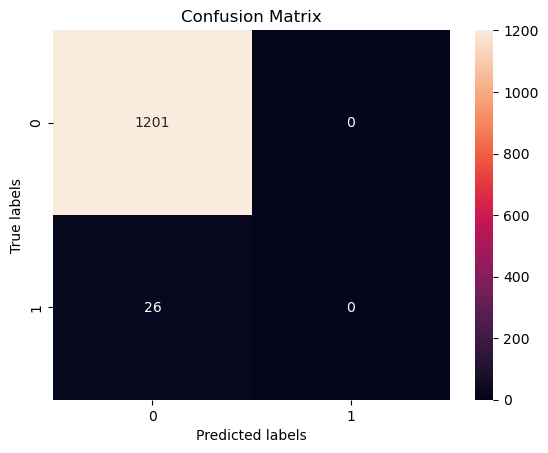

In [55]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [57]:
for text, label in zip(flat_corpus, valid_labels):
    if label == 1:
        print("---")
        print(text)


---
vid
---
sas fromager etoil list filial particip quot part capital capital propr dont resultat derni exercic clos filial etoil vercor chartrousin etoil quercy etoil fromager dauphin fromager banon particip fromager cazal rsm ouest
---
cm pag cop certifi conform depot
---
tableau fi a renseign detaill particip nouveau ava r nt affect be consent non societ e exercic clos cour exercic filial capital detenu societ re i f ee b _ renseign global concern autr filial particip non repris a filial francais ensembl filial etranger ensemb particip societ francais i f he particip societ etranger a dont valeur inventair exced certain pourcentag conform reglement cet societ dann renseign global b distingu chaqu filial entit laquel societ a lien particip indiqu denomin sieg social particip etranger suit derog inscrit in fi a monnai local oper etermin reglement capital soc a francais ensembl b filial etranger ensembl sous rubriqu e astreint publiqu lorsqu societ a annex bilan bilan compt consolid
--

In [59]:
from utils import fs

with fs.open(
    "s3://projet-extraction-tableaux/data/correct_first250.pickle", "rb"
) as f:
    df = pickle.load(f)

checked_siren = df.siren.unique()[:49]
df = df[df.siren.isin(checked_siren)]

In [64]:
df[df.tableau_f_et_p == 1]

,siren,pagenumber,text,tableau_f_et_p,accOCR,tableauPDF
92,55800296,20,LTo1 14B € Tableau des filiales et participati...,1,"85,9057450294495",1
278,300349636,69,Comptes consolidés Notes sur les comptes conso...,1,"87,6030665151938",1
279,300349636,70,Comptes consolidés Notes sur les comptes conso...,1,"86,7680165881202",1
280,300349636,71,268 Comptes consolidés Notes sur les comptes c...,1,"86,1101962697759",1
281,300349636,72,Comptes consolidés Notes sur les comptes conso...,1,"88,7639703442973",1
370,300349636,161,Comptes consolidés Notes sur les comptes conso...,1,"87,1267782473097",1
371,300349636,162,Comptes consolidés Notes sur les comptes conso...,1,"86,6281166345933",1
372,300349636,163,Comptes consolidés Notes sur les comptes conso...,1,"85,9755169612424",1
373,300349636,164,4 Note 32.2. Entreprises associées Comptes con...,1,"89,107959476594",1
569,301940219,45,L'effectif moyen représente la moyenne du pers...,1,"87,987220681006",1


In [63]:
list(df[df.tableau_f_et_p == 1].text)

["LTo1 14B € Tableau des filiales et participations (en millions d'euros) Filiales détenues à + 50% Fnac Darty Participations et Services Darty Limited Fnac Luxembourg SA Copie certifiée conforme PG / 29/06/2020 14:15:20 N° de dépôt - 2020/8525 / 055800296 Capital 325,0 155,6 0,03 Capitaux propres hors capital et résultat 232,2 8,6 0,0 Quote- part du capital détenu 99,99% 100% 100% Valeur comptable des titres détenus Brut 838,4 1116,8 0,0 Net 838,4 1116,8 0,0 Prêts consentis par Fnac Darty et non encore remboursés 354,9 0,0 0,0 Page 19 sur 27 Montant des cautions & avals donnés par Fnac Darty 0,0 0,0 0,0 Dividend Chiffre _ Bénéfice es d'affaires ou (perte) encaissé HT du du spar dernier dernier Fnac exercice exercice Dartyau écoulé clos cours de 3 832,3 134,3 0,0 0,0 (1,3) 0,0 1,8 (0,5) 0,0 \\3",
 'Comptes consolidés Notes sur les comptes consolidés NOTE 32. LISTE DES SOCIÉTÉS CONSOLIDÉES AU 31 DÉCEMBRE 2019 (% DE PARTICIPATION DU GROUPE) Note 32.1. Sociétés consolidées par intégration